# To-do list

## Metalicty

# To look into list
Hierarchical model <br>
Varitational inference <br>
Different samplers - HMC <br>
Posterior predictive checks 
Use Gyrs 



# rotaation bv and age observers GC
# period age mass and metalictty fundemental GC


In [1]:
!pip install arviz==0.11.0
!pip install pymc3==3.11.1
!pip install PyAstronomy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
#import scipy
import pandas as pd

import pymc3 as pm
import theano as tt
import arviz 
pd.options.display.max_rows = 4000
 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

print(f"Running on PyMC3 v{pm.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on PyMC3 v3.11.1


In [3]:
def mean_fn(t, B, A, c, h, f):
  return A * (t)**c  * (B-h)**f 


def log_mean_fn(log_Age, BV, A,c,h,f):
  return np.log(A) +c*log_Age + f*np.log(BV-h)




# (1+ metalicity)^( positive small power much less than 1 hundreth)
# upper bound 1/10
# higher metalicty higher period

# for latent parameters
# when we do gp.predict and pass trace


def log_err(vals, val, err_lo):
  return np.mean(np.log(vals)) - np.log(np.mean(vals)- err_lo) ## this works 



#def log_err(vals, val, err_lo):
 # return np.log(val) - np.log(val- err_lo)


#def lin_err(vals, val, err_lo):
#  return val * log_err(vals, val, err_lo)

def lin_err(val, sig_hi, sig_lo):
  return (sig_hi +sig_lo)/2
  

In [4]:
##### OPTIONS #####
#data1 16th points = 91 total






data = pd.read_csv('/content/drive/My Drive/data/real_data.csv', header=0)
flag = np.array(data['flag'])

Teff = np.array(data['Teff'])

Teff_err = np.array(data['eTeff'])

Age = np.array(data['age']) # convert to Megayrs
Age_err_lo = np.array(data['loage'])
Age_err_hi = np.array(data['upage'])

Prot = np.array(data['P'])
Prot_err_lo = np.array(data['l_P'])
Prot_err_hi = np.array(data['u_P'])

Mass  = np.array(data['modmass'])
Mass_err_lo = np.array(data['lomodmass'])
Mass_err_hi = np.array(data['himodmass'])

metal = np.array(data['feh'])

b = pyasl.BallesterosBV_T()
data_points = Prot.shape[0]


#Prot_err = np.array([lin_err(Prot, Prot[i], Prot_err_lo[i]) for i in range(data_points)])
#Age_err = np.array([lin_err(Age, Age[i], Age_err_lo[i]) for i in range(data_points)])

Age_err = np.array([lin_err(Age[i], Age_err_lo[i], Age_err_hi[i]) for i in range(data_points)])
Prot_err = np.array([lin_err(Prot[i], Prot_err_lo[i], Prot_err_hi[i]) for i in range(data_points)])


sel_good = np.where((Age > 0.5)& (Prot_err < 40) & (Mass <1.4)) # select stars that arent too young and have 'sensible' error

sel_bad = np.where((Prot < 5)& (Prot_err < 40)&(Age>5)) # Remove old stars that spin too fast

sel = (np.delete(sel_good, sel_bad))



Teff = Teff[sel]
Teff_err = Teff_err[sel]
Age = Age[sel]
Age_err_lo = Age_err_lo[sel]
Age_err_hi = Age_err_hi[sel]
Age_err = Age_err [sel]

Prot = Prot[sel]
Prot_err_lo = Prot_err_lo[sel]
Prot_err_hi = Prot_err_hi[sel]
Prot_err = Prot_err [sel]

BV =  b.t2bv(np.array(Teff))

BV_err = Teff_err/Teff * BV

data_points = Prot.shape[0]

print('Using: ',data_points)
print('From: ',data.shape)


Using:  91
From:  (94, 27)


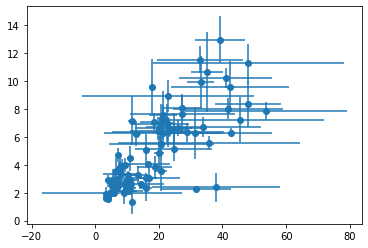

[ 0.09896664  0.10449709  0.1533777   0.16307147  0.21702951  0.24456392
  0.26752853  0.31806106  0.35731777  0.37481226  0.45559958  0.48252665
  0.49973618  0.51047451  0.51274558  0.51576927  0.52440865  0.5319714
  0.55697289  0.58397748  0.59212969  0.60819583  0.65798852  0.67727593
  0.68925145  0.72398305  0.73657433  0.78167618  0.93546604  0.99545336
  1.01004423  1.01742008  1.14356405  1.16431968  1.31998598  1.36004331
  1.40514525  1.54496817  1.57393961  1.64148053  1.64161215  1.94157594
  1.99655309  2.00864621  2.04398235  2.14367426  2.3985912   2.5167709
  2.61550219  3.23677147  3.41642965  3.68487884  4.09903918  4.17186095
  4.26738676  4.29152901  4.46553991  4.51899728  4.99462094  5.57171239
  5.61963896  5.6736072   6.37284641  6.82834684  7.17901511  7.72419753
  7.84549381  8.81341549  8.99442345 10.39939871 10.57585749 10.68987708
 11.02918412 12.17205726 13.02032401 13.53041853 14.65612622 16.48972192
 16.51971961 17.25592595 17.53369695 18.01682535 18.4

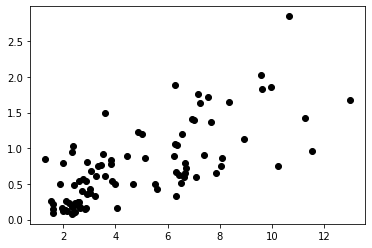

In [5]:




plt.errorbar(Prot, Age,yerr=Age_err,xerr=Prot_err,fmt='o')
plt.show()
plt.plot(Age, np.abs(Age_err), 'ok')

print(np.sort(Prot_err))

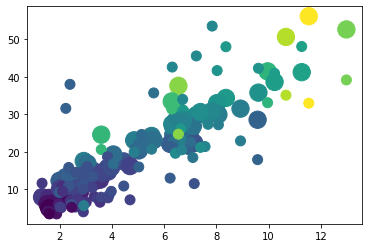

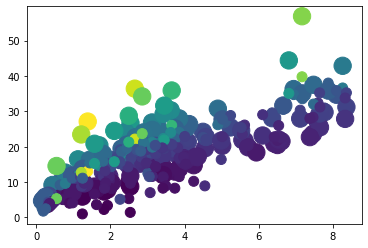

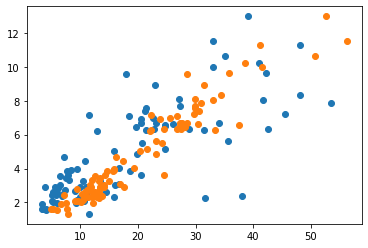

In [6]:
X = np.array([Age, BV]).T 
h = 0.4 
f = 0.601 
c = 0.52
A = 0.7725 * np.sqrt(1000)


b = pyasl.BallesterosBV_T()



Prot_guess  = mean_fn(X[:,0], X[:,1], A, c,h,f)
plt.scatter(X[:,0], Prot_guess,s=300, c=X[:,1], cmap = cm.viridis, label='model')
#plt.show()
plt.scatter(Age, Prot, c=BV,s=100,cmap = cm.viridis, label='data')

plt.show()


data2 = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)
smp_rt=10
Teff2 = data2[:,0][0::smp_rt] # Teff
Prot2 = data2[:, 1][0::smp_rt]  # Prot
Age2 = data2[:, 2][0::smp_rt]  # Age 
BV2 = b.t2bv(np.array(Teff2))

Prot_guess2 = mean_fn(Age2, BV2, A,c,h,f)

plt.scatter(Age2, Prot_guess2,s=300, c=BV2, cmap = cm.viridis, label='model')
plt.scatter(Age2, Prot2, c=BV2,s=100,cmap = cm.viridis, label='data')
plt.show()



plt.scatter(Prot, Age)
plt.scatter(Prot_guess,Age)

https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [7]:
#### book ####


h = 0.4 
f = 0.601 
c = 0.5189 
A = 0.7725 * np.sqrt(1000) 

# fix barnes values 


X = np.array([Age, BV]).T 
print(X.shape)


with pm.Model() as model:
    #c_ = pm.Uniform('c_', c-0.007, c+0.007)
    #c_ = pm.Normal('c_', c, 0.007)
    c_ = c
    #f_ = pm.Uniform('f_', f-0.024, f+0.024)
    #f_ = pm.Normal('f_', f, f*0.024)
    f_ = f
    #A_ = pm.Uniform('A_', A*0.85, A*1.15)
    #A_ = pm.Normal('A_', A, A*0.15)
    A_ = A
    
    Age_true = pm.Uniform('Age_true', 0, 14, shape=data_points)
    Age_obs = pm.Normal("Age_obs", Age_true, np.abs(Age_err), observed=X[:,0])


    

    BV_true = pm.Lognormal("BV_true", 1, 1, shape=data_points)
    BV_obs = pm.Normal("BV_obs", BV_true, np.abs(BV_err), observed=X[:,1])

    mean = mean_fn(Age_true, BV_true, A_,c_,h,f_)
    resid = Prot - mean
   
    l1 = pm.Normal('l1', mu=13, sigma=2)  # 20

    l2 = pm.Lognormal("l2", np.log(0.15), 0.1)
    #l2 = pm.Normal('l2', 0.15, 0.1)
    sf1 = pm.Normal('sf1', 10, 2)
    
    sf2 = pm.Lognormal("sf2", np.log(0.2), 0.1)
    #sf2 = pm.Normal('sf2', 0.2, 0.1)

    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2

    K = K1 * K2 # try multiply 


    gp = pm.gp.Marginal(cov_func=K)


    obs = gp.marginal_likelihood("obs", X=X , y=resid, noise=np.abs(Prot_err))

    # big gp book says constnat plus a product of linear + white noise will do the trick




(91, 2)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sf2, sf1, l2, l1, BV_true, Age_true]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 1021 seconds.


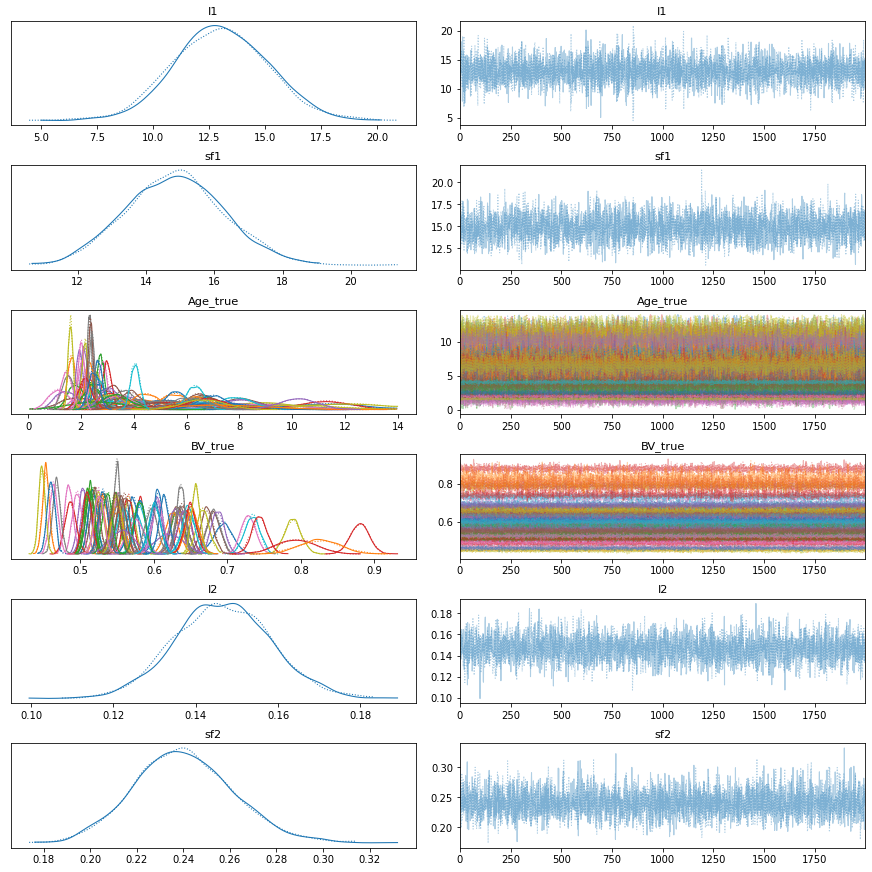

In [8]:

with model:
  trace = pm.sample(2000, tune=3000, cores=2)#, target_accept=0.95)
  arviz.plot_trace(trace)

In [9]:
with model:
  print(arviz.summary(trace))


lst = trace.varnames
lst.append('f_pred')
vars = np.asarray(lst)

with model:
  f_pred = gp.conditional('f_pred', X, pred_noise=False) # predict function
  pred_samples = pm.sample_posterior_predictive(trace, var_names=vars,samples=2500)


                mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
l1            13.026  2.100   9.207   16.990  ...  4783.0    5071.0    2543.0    1.0
sf1           14.855  1.422  12.311   17.637  ...  3827.0    3879.0    2683.0    1.0
Age_true[0]    2.934  0.395   2.208    3.696  ...  4859.0    4758.0    2334.0    1.0
Age_true[1]    1.644  0.143   1.371    1.899  ...  5326.0    5315.0    2355.0    1.0
Age_true[2]    3.300  0.726   2.017    4.709  ...  4764.0    4753.0    2399.0    1.0
Age_true[3]    2.261  0.237   1.809    2.699  ...  5123.0    5096.0    2654.0    1.0
Age_true[4]    2.128  0.127   1.903    2.376  ...  5097.0    5099.0    2711.0    1.0
Age_true[5]    6.673  0.580   5.542    7.751  ...  5422.0    5567.0    2283.0    1.0
Age_true[6]    2.828  0.162   2.521    3.121  ...  4426.0    4437.0    2950.0    1.0
Age_true[7]    8.977  1.507   5.952   11.579  ...  2850.0    3383.0    2046.0    1.0
Age_true[8]    3.430  0.656   2.213    4.643  ...  4927.0    5138

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [10]:

new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


Initianl error:  15.715380424532812 %
New error:  13.79324500227837 %
Difference in error = -1.92214%  :)


In [11]:
print(trace.get_values('Age_true').shape)
Age_new = np.mean(trace.get_values('Age_true'), axis=0)
BV_new = np.mean(trace.get_values('BV_true'), axis=0)
print(Age_new.shape)

(4000, 91)
(91,)


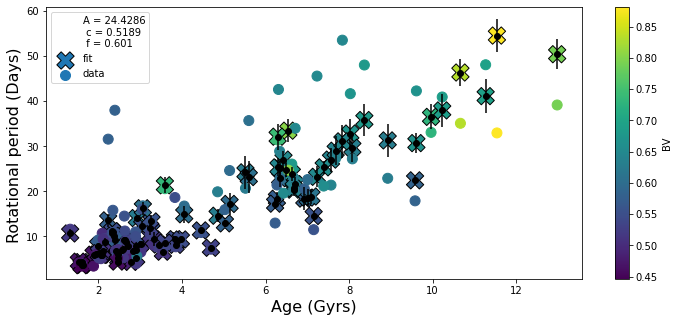

"\nfig = plt.figure(figsize=(12, 5))\nplt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')\n#plt.scatter(X[:,0], mu - fit, s=300, c=X[:,1], marker = 'o', cmap = cm.viridis, label='barnes',edgecolors='k')\nplt.scatter(X[:,0], mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601), s=300, c=X[:,1], marker = 'X', cmap = cm.viridis, label='Barnes', edgecolors='k')\nplt.xlabel('Age (Gyrs)', fontsize=16)\nplt.ylabel('Rotational period (Days) ', fontsize=16)\nplt.colorbar(label='BV')\nplt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis,label='data')\n\n\n\nplt.legend()\nplt.savefig('col_fit_comp.png')\nfiles.download('col_fit_comp.png')\n\nplt.show()\n"

In [14]:
 '''

A = np.mean(trace['A_'])
c = np.mean(trace['c_'])
h = h
f = np.mean(trace['f_'])



'''

X = np.array([Age, BV]).T 
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()



fit, var = gp.predict(X, point=trace[-1], diag=True)
sd = np.sqrt(var)


mean = mean_fn(X[:,0], X[:,1], A, c ,h,f)

mu = fit + mean



## plotting the predictions, make a plot of age on x axis b-v on y, plot points and colour by age




plt.plot([],[], color='w',label='A = {}\n c = {}\n f = {}'.format(round(A,4), round(c,4), round(f,4)))

plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 'X', cmap = cm.viridis, label='fit', edgecolors='k')


plt.errorbar(X[:,0], mu, yerr=std, fmt='ok')
#plt.errorbar(X[:,0], Prot, yerr=Prot_err, fmt='ok')

plt.xlabel('Age (Gyrs)', fontsize=16)
plt.ylabel('Rotational period (Days) ', fontsize=16)
plt.colorbar(label='BV')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis,label='data')
plt.legend()
plt.savefig('col_Ba.png')
#files.download('col_Ba.png')
plt.show()

'''
fig = plt.figure(figsize=(12, 5))
plt.scatter(X[:,0], mu, s=300, c=X[:,1], marker = 's', cmap = cm.viridis, label='fit', edgecolors='k')
#plt.scatter(X[:,0], mu - fit, s=300, c=X[:,1], marker = 'o', cmap = cm.viridis, label='barnes',edgecolors='k')
plt.scatter(X[:,0], mean_fn(X[:,0], X[:,1], 0.7725*np.sqrt(1000), 0.5189, 0.4, 0.601), s=300, c=X[:,1], marker = 'X', cmap = cm.viridis, label='Barnes', edgecolors='k')
plt.xlabel('Age (Gyrs)', fontsize=16)
plt.ylabel('Rotational period (Days) ', fontsize=16)
plt.colorbar(label='BV')
plt.scatter(Age, Prot, c=BV, s=100, cmap = cm.viridis,label='data')



plt.legend()
plt.savefig('col_fit_comp.png')
files.download('col_fit_comp.png')

plt.show()
'''

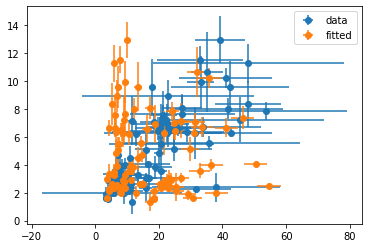

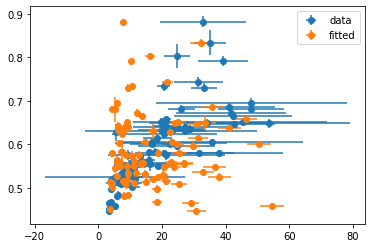

In [13]:
fit, var = gp.predict(X, point=trace[-1], diag=True)

#mu = mean + fit
std = np.sqrt(var) * np.sign(var)



vals = np.sort(np.array([mu, std, Prot, Prot_err]), axis=1)





age_fit_err = [trace.get_values('Age_true')[:,i].std() for i in range(trace.get_values('Age_true').shape[1])]
bv_fit_err = [trace.get_values('BV_true')[:,i].std() for i in range(trace.get_values('BV_true').shape[1])]


plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(vals[0,:], X[:,0], xerr=vals[1,:], yerr=age_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='data')



order = np.argsort(X[:,1])


plt.errorbar(vals[0,:][order], X[:,1][order], xerr=vals[1,:][order], yerr=bv_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

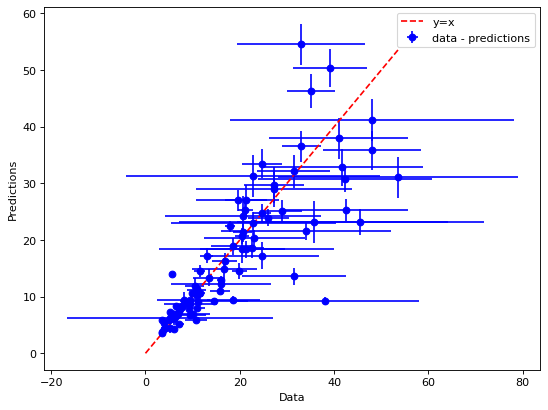

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

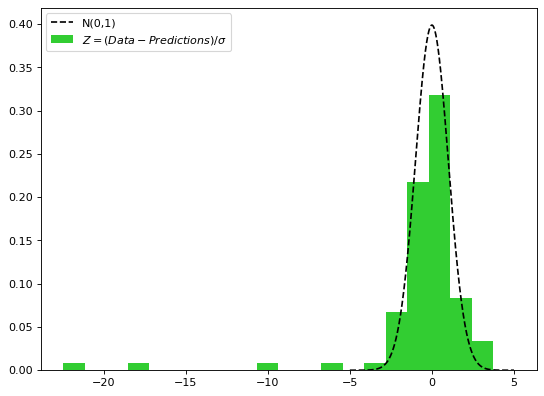

-0.5469196343602039


In [29]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot([0, np.amax(vals[2,:])], [0, np.amax(vals[2,:])], linestyle='--', label='y=x', color='r')


plt.errorbar(Prot, mu, yerr=std, xerr=Prot_err, fmt='o', label=r'data - predictions', color='b', alpha=1)



#plt.fill_between(vals[2,:], vals[0,:] - vals[1,:], vals[0,:] + vals[1,:], alpha=0.3, label=r'$\sigma$',interpolate=True, color='blue')
#plt.fill_between(vals[2,:], vals[0,:] - 2*vals[1,:], vals[0,:] + 2*vals[1,:], alpha=0.2, label=r'$2\sigma$', interpolate=True, color='b')
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.savefig("R_Ba.png")
files.download("R_Ba.png") 
plt.legend()
plt.xlabel('Data')
plt.ylabel('Predictions')
plt.show()


Z = (Prot - mu)/np.sqrt(std**2 + Prot_err**2)
x = np.linspace(-5,5, 1000)
norm = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hist(Z, density=True, label=r'$Z=(Data-Predictions)/\sigma$', color='limegreen', bins=20)
plt.plot(x,norm, label='N(0,1)', color='k', linestyle='--')
plt.legend()
plt.savefig("H_Ba.png")
files.download("H_Ba.png") 
plt.show()
print(Z.mean())



In [53]:
print(np.mean(Z))

print(np.std(Z))

print(len(Z))

k = np.argsort(Z)

print('rot',Prot[k[:4]])
print('age',Age[k[:4]])
print(BV[k[:4]])
print(Prot_err[k[:4]])
mass  = np.array(data['modmass'])
print(mass[k[:4]])
metal = np.array(data['feh'])
print(metal[k[:4]])
print(len(mass[mass < 1.4]))
print(np.sort(mass))

'''
have found that stars above the kraft break 1.3 do not follow the patterns we are expecting, so we are going to remove stars above. Consistent with kfraft break where we get shallowe
convective zones, torques dynamos etc.
agreeing wiht eh metalcity paper, have found that lower metalicty stars spin slower. 


compare with all stars, outliars 3 high mass 1 very metal poor. Kill x most massive stats, if the new run has more massive outliars kill y more. Would be best to go as high
as we can. If we can disprove the Kraft Break, its gonna be a continuum. If our model can account for these high mass stars, can speculate validty of Kraft break
'''

-0.5469196343602039
3.3686946752748
91
rot [5.62466957 3.4137859  5.25643289 5.06509836]
age [2.9206 1.8825 2.6    2.0582]
[0.62800803 0.46583742 0.51424067 0.51289009]
[0.26752853 0.10449709 0.1533777  0.09896664]
[1.509  1.497  1.1384 1.5279]
[ 0.22  0.26 -0.42 -0.05]
79
[0.728  0.739  0.8115 0.8287 0.8287 0.899  0.899  0.918  0.918  0.918
 0.9214 0.9389 0.9693 0.9693 0.9693 0.9693 0.9788 0.9883 0.9883 0.9883
 1.0092 1.019  1.0377 1.0377 1.0491 1.0586 1.0586 1.0586 1.059  1.059
 1.059  1.068  1.068  1.068  1.0681 1.0776 1.089  1.0985 1.099  1.108
 1.108  1.117  1.117  1.1194 1.1194 1.1289 1.1384 1.1479 1.148  1.159
 1.1593 1.1593 1.1688 1.1688 1.178  1.178  1.1783 1.1878 1.197  1.199
 1.2087 1.209  1.228  1.239  1.239  1.2581 1.2885 1.298  1.298  1.3189
 1.3379 1.3379 1.3683 1.3683 1.3778 1.3778 1.3987 1.3987 1.3987 1.4082
 1.4082 1.4177 1.418  1.4291 1.4481 1.469  1.469  1.497  1.4975 1.5089
 1.509  1.5279 1.5279 1.5678]


'\nhave found that stars above the kraft break 1.3 do not follow the patterns we are expecting, so we are going to remove stars above. Consistent with kfraft break where we get shallowe\nconvective zones, torques dynamos etc.\nagreeing wiht eh metalcity paper, have found that lower metalicty stars spin slower. \n\n\ncompare with all stars, outliars 3 high mass 1 very metal poor. Kill x most massive stats, if the new run has more massive outliars kill y more. Would be best to go as high\nas we can. If we can disprove the Kraft Break, its gonna be a continuum. If our model can account for these high mass stars, can speculate validty of Kraft break\n'

In [ ]:
  
### Fix B-V for sveral valuea and plot age vs roation for Barnes and GP. Should see that for Young stars, Barnes and GP agree fairly well as Barnes callibrated on young stars. On Older Barnes will be bad. GP has more flexibility. Should wee GP predicticint faster than Barnes.

#histogram of the differences between old uncertaintiy and new uncertainity(latent variables SD)
new_err = ([ trace.get_values('Age_true')[:,i].std()for i in range(data_points)])
old_err = Age_err
plt.hist(old_err - new_err)
plt.show()
plt.plot(old_err, new_err,'o')
plt.plot([0,3], [0,3])
plt.xlabel('old error')
plt.ylabel('New error')
plt.savefig('err_diff_Ba.png')
files.download('err_diff_Ba.png')
# give this a section 

In [ ]:
new_err = np.mean([ trace.get_values('Age_true')[:,i].std()/  trace.get_values('Age_true')[:,i].mean() for i in range(data_points)])
old_err =np.mean(np.abs(Age_err/Age))


print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("Difference in error = {}%  :)".format(round((new_err-old_err)*100,5)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


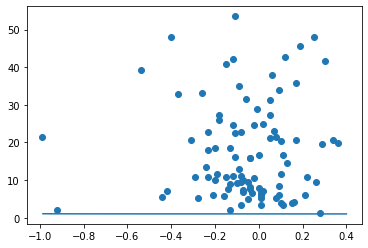

These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

Second fast component t the gp when we dont have B-V